## Studying the Effect of Edge Removal on VNE
### Jeremy Kazimer
### Dane Taylor
### 8/7/2021

#### _Import Statements_

In [13]:
# Data structures
import numpy as np
import pandas as pds

# System and utility
import os, sys
sys.path.append('utility')

from VNE_util import *
from graphs_util import *

# Plots and graphs
from matplotlib import pyplot as plt

####  _Make a network_

For the purposes of this experiment, we'll be operating on Erdos-Renyi random graphs ($G_{NP}$) with parameters $N$ (network size) and $p$ (edge probability).  As such, we'll use our utility code below:

In [14]:
# Make an Erdos-Renyi Gnm graph

# Number of nodes
N = 100 

# Inside edge probability
M = 1500

A = Erdos_Renyi_Gnm(N, M)

In [15]:
print('edges: {}'.format(np.sum(A)/2))

edges: 1500.0


Of course, we can spy the network to get a feel of it:

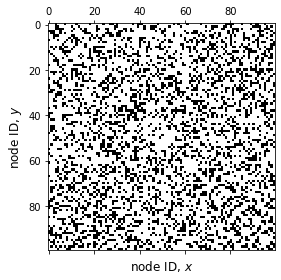

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

ax.spy(A)

ax.set_ylabel('node ID, $y$', fontsize = 12)
ax.set_xlabel('node ID, $x$', fontsize = 12)

fig.tight_layout()

#### _Computing its VNE_

 
For this graph, general VNE of a spectral distribution is defined as
$$
h = - \sum_{i = 1}^{N} \rho(\lambda_i) \log_2 \rho(\lambda_i).
$$
Letting $\beta >0$ be a time scale parameter, we study when 
$$
\rho(\{\lambda\}) \triangleq \frac{e^{-\beta\lambda_i}} {\sum_{j = 1}^{N} e^{-\beta\lambda_{j}}}.
$$

In [17]:
# Compute initial VNE

# Diffusion rate
beta = 1

# Base entropy
h0 = B_entropy(A, beta = beta).sum()

print('base entropy: {}'.format(h0))

base entropy: 3.8295979580809435e-06


Now, to study how this changes upon removal, we can simulate that with perturbation theory.

#### _Graph Removals_

Given a Laplacian $L$ and a perturbed laplacian $L + \Delta L$, we study $h(L)$ and $h(L + \epsilon \Delta L)$ so that we can transform $L$ into  $\Delta L$ by letting $\epsilon \in[0,1]$.



Let $L=U\Lambda U^T$ denote a diagonalizable, symmetric Laplacian matrix and consider a structural perturbation encoded my matrix $\epsilon \Delta L$ for $\epsilon\ge0$. Consider VNE with density matrix $\rho(L)$ defined using the heat-kernel method. Then the VNE  $H(\epsilon)$ that is associated with $L +\epsilon \Delta L$ has the following first-order approximation
$$
H(\epsilon) = H(0) + \epsilon H'(0) + \mathcal{O}(\epsilon^{2}),
$$


$$
H'(0) = \beta \sum_{i = 1}^{N} \left[f_i(\{\lambda\})\log_2\left(f_i(\{\lambda\})\right)  + \frac{f_i(\{\lambda\})}{\ln\left(2\right)}\right]\left[\lambda_{i}'(0) - \sum_{j = 1}^{N}f_j(\{\lambda\})\lambda_j'(0)\right].
$$

Here,  $\rho(\lambda_i) = f_i(\{\lambda\}) $ and $\lambda_i'(0) = v_i^{(T)} \Delta L v_i$ such that $v_i$ is an eigenvector corresponding to the $i$-th eigenvalue. 



In [18]:
# Number of rewires
K = 20

# Epsilon values
epsilons = np.logspace(-3, 0, 11)

# Entropy arrays
H_act = np.zeros((len(epsilons), K+1)) # actual VNE
H_est = np.zeros((len(epsilons), K+1)) # estimated VNE

# Copy the original network, so it doesn't get modified.

L = laplacian(A)
eigs, vecs = np.linalg.eigh(L)
A1 = A.copy()

f = np.exp(-beta*eigs)
f /= np.sum(f)

dhdf = f*(-np.log2(f) + 1/np.log(2))

edges = get_edges(A)
np.random.shuffle(edges)
for t in range(K + 1):
    edge = edges[t]
    
    dL = laplacian(A1) - L
    for idx, epsilon in enumerate(epsilons):
        H_act[idx, t] = B_entropy(epsilon*A1 + (1 - epsilon)*A, beta).sum()
        H_est[idx, t] = h0 + B_perturbation(dL, eigs, vecs, f, dhdf, epsilon, beta).sum()
        
    _ = remove_edge(A1, edge) 

And of course we can plot this now that everything has ran:

In [19]:
save = False

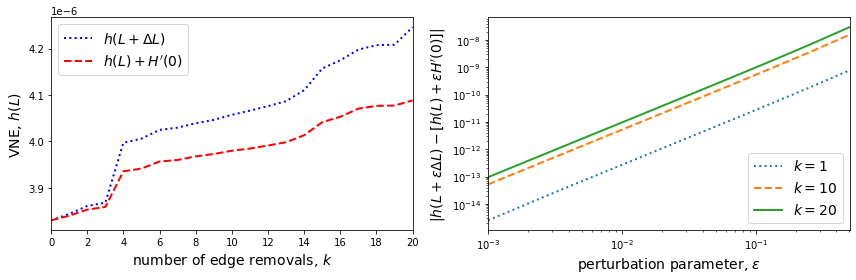

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# Pertubation plot
axs[0].plot(H_act[-1], lw = 2, c = 'blue', ls = ':', label = '$h(L + \Delta L)$')
axs[0].plot(H_est[-1], lw = 2, c = 'red', ls = '--', label = '$h(L) + H\'(0)$')

axs[0].set_xticks(range(0, K + 1, 2))
axs[0].set_xlim(0, K)

axs[0].legend(loc = 'upper left', fontsize = 14)

axs[0].set_xlabel('number of edge removals, $k$', fontsize = 14)
axs[0].set_ylabel('VNE, $h(L)$', fontsize = 14)

# Error plot
axs[1].loglog(epsilons[:-1], abs(H_est - H_act)[:-1][:,1], lw = 2, ls = ':', label = '$k = 1$')
axs[1].loglog(epsilons[:-1], abs(H_est - H_act)[:-1][:,10], lw = 2, ls = '--', label = '$k = 10$')
axs[1].loglog(epsilons[:-1], abs(H_est - H_act)[:-1][:,20], lw = 2, label = '$k = 20$')

axs[1].set_xlim(np.min(epsilons[:-1]), np.max(epsilons[:-1]))

axs[1].legend(loc = 'lower right', fontsize = 14)

axs[1].set_xlabel('perturbation parameter, $\epsilon$', fontsize = 14)
axs[1].set_ylabel('$|h(L+\epsilon\Delta L) - [h(L) + \epsilon H\'(0)]|$', fontsize = 14)

fig.tight_layout()

if save == True:
    fig.savefig('figs/removal_validation.pdf')

#### We can see here that it isn't precisely fitting, specifically that over time it deviates from the actual curve, but where does the error lie? This is where the righthand plot comes in.  The slope of that line will tell us where the error exists.

In [22]:
ms = [np.polyfit(np.log(epsilons[:-1]), np.log(abs(H_est-H_act))[:-1][:, idx], 1)[0] for idx in range(1, K + 1)]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11508\3713980626.py:1: RuntimeWarning: divide by zero encountered in log
  ms = [np.polyfit(np.log(epsilons[:-1]), np.log(abs(H_est-H_act))[:-1][:, idx], 1)[0] for idx in range(1, K + 1)]


In [23]:
ms[0], ms[9], ms[19]

(2.025654568006689, 2.021951610632944, 2.0268111200857692)

---